In [1]:
import pandas as pd, numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import sklearn
from sklearn_pandas import DataFrameMapper
%matplotlib inline

In [2]:
IN_DATAFILE='https://s3.amazonaws.com/rorodata-datasets/lending-club-data.csv'
loans = pd.read_csv(IN_DATAFILE, infer_datetime_format = True)
loans.columns

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [3]:
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
           ]
label_col = 'bad_loans'

In [4]:
clean_data=loans[features+[label_col]].dropna()

In [5]:
numerical_cols=['sub_grade_num', 'short_emp', 'emp_length_num','dti', 'payment_inc_ratio', 'delinq_2yrs', \
                'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none', 'open_acc',\
                'pub_rec', 'pub_rec_zero','revol_util']


X2=np.array(clean_data[numerical_cols])
y = np.array(clean_data['bad_loans'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=100, stratify=y)

In [14]:
models = { 'rand_f':RandomForestClassifier(), 
          'knn':KNeighborsClassifier(), 
          
         }

for model_key in models:
    model = models[model_key]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = accuracy_score(y_test, preds)
    print("Accuracy for {0}: {1}".format(model_key, f1))

Accuracy for rand_f: 0.8009443524263924
Accuracy for knn: 0.7820573038985439


Visualizing feature importance for knn model

In [9]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_train)
interpreter.load_data(X_test)
model = InMemoryModel(models['knn'].predict_proba, examples=X_test)
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True, n_samples=50000)


2019-05-30 00:54:53,244 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[14/14] features ████████████████████ Time elapsed: 77 seconds

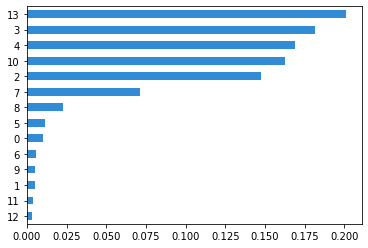

In [ ]:
plots[0]

Visualizing both RandomForest and KNN model for global feature importance

rand_f


2019-05-30 01:15:17,701 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[14/14] features ████████████████████ Time elapsed: 56 secondsknn


2019-05-30 01:16:26,464 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[14/14] features ████████████████████ Time elapsed: 63 seconds

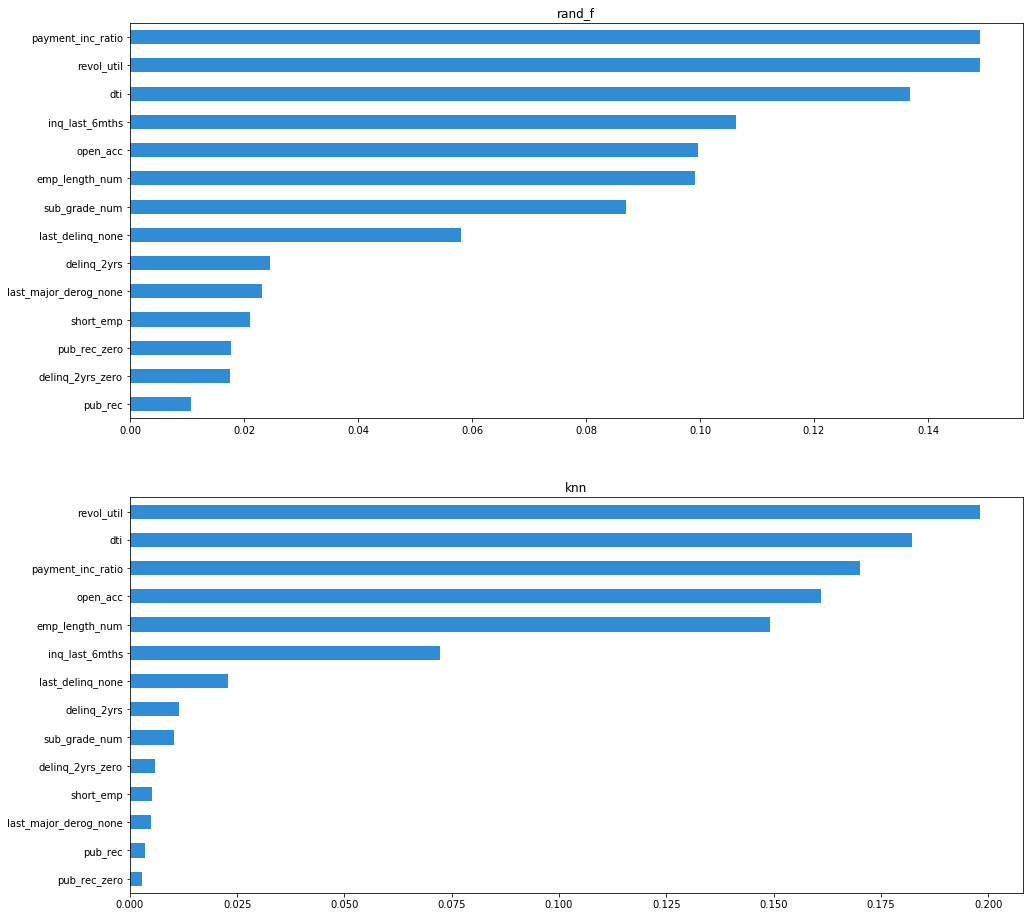

In [18]:
f, axes = plt.subplots(2,1, figsize = (16, 16))
ax_dict = {
    'rand_f':axes[0],
    'knn':axes[1]
}


interpreter = Interpretation(X_test, feature_names=numerical_cols)

for model_key in models:
    print(model_key)
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_train)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ax=ax, ascending = True,n_samples=50000)
    ax.set_title(model_key)